In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
inputFiles = ['../scanResults_axial.pcl', '../scanResults_vector.pcl']
dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)

### Get all model points

In [3]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$', '$g_{DM}$', '$g_{q}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

353 models loaded.


### Get models parameters

In [4]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Vector', 'Axial'], 'Mode': 'DM+QCDjets', '$m_{med}$': [450.0, 1250.0, 100.0, 2500.0, 200.0, 1000.0, 2250.0, 300.0, 750.0, 400.0, 2000.0, 500.0, 1750.0, 3000.0, 250.0, 1500.0, 2750.0], '$m_{DM}$': [1.0, 900.0, 1400.0, 650.0, 400.0, 150.0, 30.0, 800.0, 40.0, 300.0, 45.0, 1200.0, 50.0, 55.0, 700.0, 60.0, 450.0, 70.0, 200.0, 75.0, 1100.0, 80.0, 600.0, 90.0, 1500.0, 350.0, 100.0, 1000.0, 750.0, 500.0, 120.0, 250.0], '$g_{DM}$': 1.0, '$g_{q}$': 0.25}
Coupling = ['Vector', 'Axial']
Mode = DM+QCDjets
$g_{DM}$ = 1.0
$g_{q}$ = 0.25


### Filter parameters

In [13]:
paramFilter = {
    'Mode' : 'DM+QCDjets',
    '$m_{med}$' : 100.,
    '$m_{DM}$' : 1.,
    '$g_{DM}$' : 1.,
    '$g_{q}$' : .25,
    'Data-takingperiod' : 2018
}

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in paramFilter.items()])
dfModel = recastData.loc[(recastData[list(paramFilter)] == pd.Series(paramFilter)).all(axis=1)]

The efficiency for the $i$-th bin, $\epsilon_{i}$, is given by:

$$ \epsilon_{i} = \frac{n^{i}_{s}}{\sigma_{T}\mathcal{L}},   $$
where $n^{i}_{s}$ is the number of events in the correspondent bin, $\sigma_{T}$ is the total cross-section, and $\mathcal{L}$ is the integrated luminosity.  

### Auxiliar functions for plotting

In [11]:
def getBins(dfModel,rightBin = 2000.):
    
    bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and not 'Error' in c)}
    binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}    
    binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
    binLeft = [bins[c] for c in bins]+[rightBin] 
    
    return bins,binsError,binCenter,binLeft


def getEfficiencies(dfSingle, bins):
    
    xsec = dfSingle['Total xsec (pb)'].iloc[0]
    lumi = dfSingle['Luminosity (1/fb)'].iloc[0]
    eff = {c : dfSingle[c].iloc[0]/(xsec*lumi) for c in bins}
    
    return eff

### Plot Efficiencies

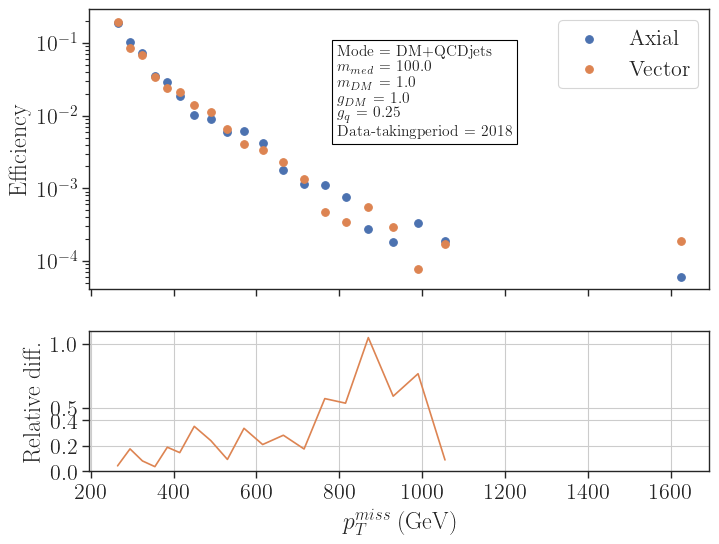

In [56]:
bins, binsError, binCenter, binLeft = getBins(dfModel)

fig, ax = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(8,6))

data = pd.DataFrame(columns=['Axial', 'Vector'])

for label in dfModel['Coupling']:
    dfSingle = dfModel[dfModel['Coupling'] == label]
    data[label] = getEfficiencies(dfSingle, bins)
    eff = np.array([data[label][c] for c in bins])
    
    ax[0].scatter(x=binCenter, y=eff, s=30, color=colors[label], label=label)

diff = np.abs(data.Axial - data.Vector)/data.Axial

ax[1].plot(binCenter, diff, color=colors[label])

    
ax[0].set_yscale('log')
ax[0].text(.4, 2.4, textstr, fontsize=11, bbox=dict(facecolor='none', edgecolor='black'), 
           transform=plt.gca().transAxes)



ax[0].set_ylabel('Efficiency')
ax[0].legend()

ax[1].set_ylim(0., 1.1)
ax[1].grid(True)
ax[1].set_yticks([0., 0.2, 0.4, 0.5, 1.])
ax[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')
ax[1].set_ylabel('Relative diff.')

plt.show()

In [52]:
diff

bin_250.0_280.0      0.043495
bin_280.0_310.0      0.176773
bin_310.0_340.0      0.082063
bin_340.0_370.0      0.037195
bin_370.0_400.0      0.189864
bin_400.0_430.0      0.147349
bin_430.0_470.0      0.353751
bin_470.0_510.0      0.241670
bin_510.0_550.0      0.093875
bin_550.0_590.0      0.338320
bin_590.0_640.0      0.210948
bin_640.0_690.0      0.283898
bin_690.0_740.0      0.175943
bin_740.0_790.0      0.571826
bin_790.0_840.0      0.535914
bin_840.0_900.0      1.051137
bin_900.0_960.0      0.590728
bin_960.0_1020.0     0.767299
bin_1020.0_1090.0    0.089814
bin_1090.0_1160.0         NaN
bin_1160.0_1250.0         NaN
bin_1250.0_1400.0    2.123644
dtype: float64